<a href="https://colab.research.google.com/github/silasyl/DatathONS-Time2/blob/main/DatathONS_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### <b>DatathONS 2022 - Remoção de Viés de Previsão de Ventos </b> 

Este notebook é resultado do estudo realizado durante a terceira edição do DatathONS, <i>hackaton</i> de dados promovido pelo Operador Nacional do Sistema Elétrico (ONS) que abordou desafio relacionado à remoção de viés em dados de previsão de ventos, com o objetivo de melhorar a acurácia dos modelos de previsão eólica e fotovoltaica, utilizadas no planejamento de curto prazo.

<b>Links:</b>

>[Dataset](https://dados.ons.org.br/dataset/datathons-3a-edicao)



<b> Equipe:</b>
<br>
* André Saimon
* Fabiana de Souza
* Pedro Florencio de A. Neto
* Mariana Bressan
* Silas Liu
<br>
---



#### <b> 1. Introdução </b>

A geração eólica constitui uma parcela significativa da matriz energética brasileira. Por se tratar de uma fonte dependente de fatores climáticos, está exposta a diversas incertezas, e, portanto, desvios de previsão tornam-se inevitáveis. Os desvios significativos podem provocar situações que demande o redespacho hidrotérmico. Como consequência dessa ação, o custo de operação é elevado, gerando mais encargos e aumento das tarifas pagas pelo consumidor. Sendo assim, é importante que o ONS disponha de ferramentas cada vez mais capazes de fornecer previsões acuradas das fontes renováveis.


#### <b> 2. Objetivos </b>


* Explorar o dataset a fim de entender o comportamento dos modelos de previsão e seus erros para as usinas;
* Comparar 2 modelos de regressão que aplicam não linearidades em uma das usinas no dataset disponibilizado pelo desafio;
* Comparar os modelos de regressão com o modelo estatístico SARIMAX.


#### <b> 3. Análise Exploratória dos Dados</b>

Esta etapa consiste em analisar e entender o dataset, buscando uma compreensão do problema proposto. Iremos realizar:

* Importação das bibliotecas de análise, visualização e tratamento dos dados;
* Investigação das principais informações do dataset;
* Verificação de como os dados se distribuem;
* Identificação dos dados ausentes.

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

##### <b> 3.1 Entrada dos Dados<b>

In [9]:
# Função de leitura dos dados
def read_wind_data(dir_name='wind_dataset'):
    """
    Função que faz leitura de todos os arquivos de dados de ventos e retorna um dataframe contendo todos os dados.
    Presume-se que os dados de vento são em intervalos de meia hora.
    A pasta precisa ter apenas arquivos de vento, formato txt.
    
    Args:
        dir_name (str, optional): string com o nome do diretório onde os dados estão
        
    Returns:
        df: pandas dataframe contendo as informações dos arquivos lidos.
            Cada coluna é uma usina e os index das linha são timestamps, ordenados.
    """
    path = os.path.join(os.getcwd(), dir_name)
    df = pd.DataFrame()
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('txt'):
                df_temp = pd.read_csv(file_path, header=None, sep=';')
                df_temp[0] = pd.to_datetime(df_temp[0], format='%Y%m%d')
                df_temp.set_index(0, drop=True, inplace=True)
                init_date = df_temp.index[0]
                last_date = df_temp.index[-1] + timedelta(days=1) - timedelta(minutes=30)
                df_temp = df_temp.stack(dropna=False)
                df_temp.index = pd.date_range(init_date, last_date, freq='30T')
                df = pd.concat([df, pd.DataFrame(df_temp, columns=[file])], axis=1)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [10]:
df = read_wind_data()
df.head()

,U10_Ven_Prev.txt,U10_Ven_Verif.txt,U11_Ven_Prev.txt,U11_Ven_Verif.txt,U12_Ven_Prev.txt,U12_Ven_Verif.txt,U13_Ven_Prev.txt,U13_Ven_Verif.txt,U14_Ven_Prev.txt,U14_Ven_Verif.txt,...,U5_Ven_Prev.txt,U5_Ven_Verif.txt,U6_Ven_Prev.txt,U6_Ven_Verif.txt,U7_Ven_Prev.txt,U7_Ven_Verif.txt,U8_Ven_Prev.txt,U8_Ven_Verif.txt,U9_Ven_Prev.txt,U9_Ven_Verif.txt
2017-01-01 00:00:00,3.8796,3.2332,NaN,1.2080,NaN,1.1268,NaN,1.7056,NaN,1.9205,...,2.9649,3.0499,2.6004,4.4208,4.5385,3.7831,4.7348,3.2173,4.5700,3.2301
2017-01-01 00:30:00,3.8306,3.0635,NaN,1.0023,NaN,0.6833,NaN,1.8107,NaN,2.2813,...,2.9316,2.7315,2.5076,4.4953,4.5385,3.4434,4.5437,3.2036,4.5069,3.1167
2017-01-01 01:00:00,3.7815,2.7986,NaN,0.8058,NaN,0.7950,NaN,3.8786,NaN,2.7579,...,2.8983,2.4952,2.4147,3.8723,4.5385,3.7608,4.3527,3.3689,4.4439,2.7939
2017-01-01 01:30:00,3.7377,3.0123,NaN,1.0192,NaN,1.1210,NaN,3.7506,NaN,2.7623,...,2.9053,2.8445,2.3656,3.5962,4.4579,3.0795,4.1530,3.7987,4.3843,2.7652
2017-01-01 02:00:00,3.6939,2.9413,NaN,1.0742,NaN,1.0895,NaN,2.6184,NaN,2.3249,...,2.9123,2.9139,2.3166,3.5529,4.3773,2.7538,3.9532,3.9098,4.3247,2.8384


In [11]:
df.shape

(70128, 28)

> Foi realizado um tratamento nos dados de entrada, que eram compostos por leituras em .txt das usinas. Formou-se um dataframe,  constituído por 70128 amostras que indicam o tempo, variando a cada 30 minutos, tendo início em 2017. Além disso, é formado por 28 colunas, que representam a velocidade de vento prevista pelo modelo GFS para cada uma das 14 usinas e a velocidade real.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70128 entries, 2017-01-01 00:00:00 to 2020-12-31 23:30:00
Freq: 30T
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   U10_Ven_Prev.txt   68732 non-null  float64
 1   U10_Ven_Verif.txt  70128 non-null  float64
 2   U11_Ven_Prev.txt   61822 non-null  float64
 3   U11_Ven_Verif.txt  70128 non-null  float64
 4   U12_Ven_Prev.txt   61822 non-null  float64
 5   U12_Ven_Verif.txt  70128 non-null  float64
 6   U13_Ven_Prev.txt   61822 non-null  float64
 7   U13_Ven_Verif.txt  70128 non-null  float64
 8   U14_Ven_Prev.txt   61822 non-null  float64
 9   U14_Ven_Verif.txt  70128 non-null  float64
 10  U1_Ven_Prev.txt    68684 non-null  float64
 11  U1_Ven_Verif.txt   70128 non-null  float64
 12  U2_Ven_Prev.txt    68684 non-null  float64
 13  U2_Ven_Verif.txt   70128 non-null  float64
 14  U3_Ven_Prev.txt    68732 non-null  float64
 15  U3_Ven_Verif.txt   70128 

In [13]:
df.describe()

,U10_Ven_Prev.txt,U10_Ven_Verif.txt,U11_Ven_Prev.txt,U11_Ven_Verif.txt,U12_Ven_Prev.txt,U12_Ven_Verif.txt,U13_Ven_Prev.txt,U13_Ven_Verif.txt,U14_Ven_Prev.txt,U14_Ven_Verif.txt,...,U5_Ven_Prev.txt,U5_Ven_Verif.txt,U6_Ven_Prev.txt,U6_Ven_Verif.txt,U7_Ven_Prev.txt,U7_Ven_Verif.txt,U8_Ven_Prev.txt,U8_Ven_Verif.txt,U9_Ven_Prev.txt,U9_Ven_Verif.txt
count,68732.000000,70128.000000,61822.000000,70128.000000,61822.000000,70128.000000,61822.000000,70128.000000,61822.000000,70128.000000,...,68684.000000,70128.000000,68684.000000,70128.000000,68732.000000,70128.000000,68684.000000,70128.000000,68684.000000,70128.000000
mean,2.794038,2.615297,2.281644,2.629478,2.044745,2.436056,1.939240,2.460414,1.685643,2.467049,...,2.424878,2.649539,2.347649,2.930076,2.482215,2.644257,2.533737,3.014427,2.978376,2.831357
std,0.752064,0.674061,0.939546,0.954966,0.969182,1.205962,0.819194,1.011634,0.695096,0.954380,...,0.732495,0.650943,0.873700,0.985148,1.115729,1.027447,1.148930,1.167537,1.027215,0.875735
min,0.091100,0.389100,0.003500,0.323200,0.007000,0.293600,0.007000,0.000000,0.003500,0.293600,...,0.077100,0.293600,0.059600,0.293600,0.000000,0.293600,0.014000,0.263600,0.003500,0.293600
25%,2.302500,2.172100,1.619100,1.947900,1.331800,1.488500,1.328300,1.789300,1.181100,1.835500,...,1.948600,2.236700,1.717300,2.279400,1.630975,1.931925,1.685700,2.144400,2.253500,2.251700
50%,2.812500,2.586000,2.250000,2.593300,1.966100,2.258000,1.934600,2.470250,1.662900,2.494750,...,2.481300,2.669700,2.356900,2.859500,2.414700,2.587600,2.432200,2.900200,3.002600,2.809000
75%,3.317100,3.063500,2.884300,3.219600,2.668800,3.190900,2.526800,3.144100,2.162400,3.120200,...,2.947400,3.082600,2.996500,3.523600,3.334700,3.250400,3.311900,3.862700,3.714900,3.354200
max,5.439200,5.090700,7.948500,7.430900,7.082800,9.269900,6.739400,11.139200,6.581700,9.671100,...,4.804800,9.720100,5.018600,11.416500,6.595700,11.147500,6.827000,8.493000,6.273300,8.964300


##### <b> 3.2 Verificando a presença de valores ausentes </b>

<Figure size 1080x720 with 0 Axes>

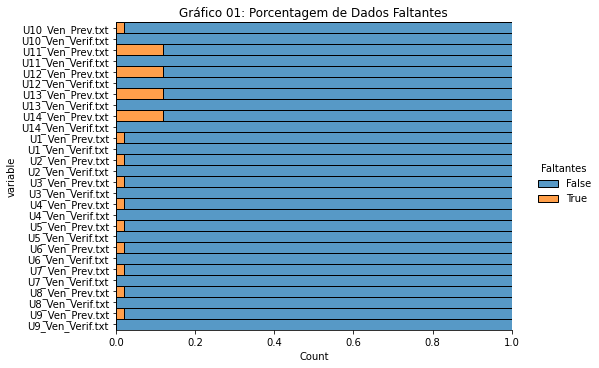

In [14]:
plt.figure(figsize=(15,10))
sns.displot(
    data=df.isna().melt(value_name="Faltantes"),
    y="variable",
    hue="Faltantes",
    multiple="fill",
    aspect=1.50
)
plt.title('Gráfico 01: Porcentagem de Dados Faltantes')
plt.show()


In [15]:
round(df.isnull().sum()/len(df.index), 2)*100 # Porcentagem de dados faltantes 

U10_Ven_Prev.txt      2.0
U10_Ven_Verif.txt     0.0
U11_Ven_Prev.txt     12.0
U11_Ven_Verif.txt     0.0
U12_Ven_Prev.txt     12.0
U12_Ven_Verif.txt     0.0
U13_Ven_Prev.txt     12.0
U13_Ven_Verif.txt     0.0
U14_Ven_Prev.txt     12.0
U14_Ven_Verif.txt     0.0
U1_Ven_Prev.txt       2.0
U1_Ven_Verif.txt      0.0
U2_Ven_Prev.txt       2.0
U2_Ven_Verif.txt      0.0
U3_Ven_Prev.txt       2.0
U3_Ven_Verif.txt      0.0
U4_Ven_Prev.txt       2.0
U4_Ven_Verif.txt      0.0
U5_Ven_Prev.txt       2.0
U5_Ven_Verif.txt      0.0
U6_Ven_Prev.txt       2.0
U6_Ven_Verif.txt      0.0
U7_Ven_Prev.txt       2.0
U7_Ven_Verif.txt      0.0
U8_Ven_Prev.txt       2.0
U8_Ven_Verif.txt      0.0
U9_Ven_Prev.txt       2.0
U9_Ven_Verif.txt      0.0
dtype: float64

>❗️ Há valores faltantes referentes aos ventos previstos pelo modelo. O tratamento destes dados é de suma importância para concepção do modelo com bom desempenho. Uma estratégia adotada que poderia ser adotada é sobrepor os dados provenientes do ERA5. Primeiro, adotaremos o uso dos valores da mediana dos ventos para aquela usina.

##### <b> 3.3 Análise das Séries Temporais </b>

> Entender o comportamento das séries temporais de cada usina é de suma importância para analisar o comportamento do vento e dos modelos em cada uma delas. Primeiro focou-se na Usina 1.

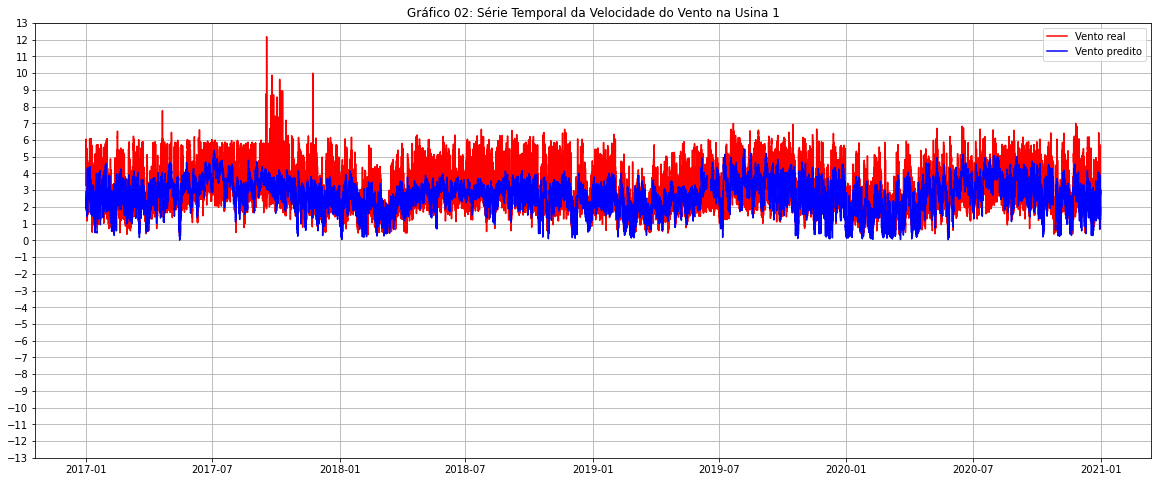

In [16]:
plt.figure(figsize=(20,8))
plt.title('Gráfico 02: Série Temporal da Velocidade do Vento na Usina 1')
plt.grid('whitegrid')

plt.plot(df.loc[:, 'U1_Ven_Verif.txt'], color='r', label = 'Vento real')
plt.plot(df.loc[:, 'U1_Ven_Prev.txt'], color='b', label = 'Vento predito')
plt.yticks(np.arange(-13,14))
plt.legend()

plt.show()

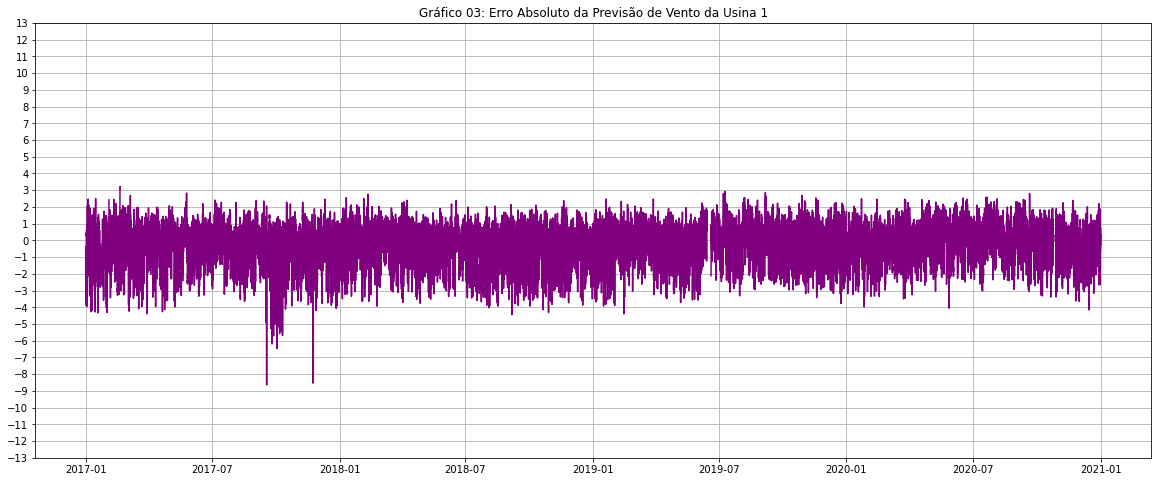

In [17]:
plt.figure(figsize=(20,8))
plt.title('Gráfico 03: Erro Absoluto da Previsão de Vento da Usina 1')
plt.grid('whitegrid')

# Erro absoluto
plt.plot(df.loc[:, 'U1_Ven_Prev.txt'] - df.loc[:, 'U1_Ven_Verif.txt'], color='purple', label = 'Vento real')

plt.yticks(np.arange(-13,14))

plt.show()

> Este é o comportamento do erro para a Usina 1. É obtido através da subtração do valor previsto pelo modelo e o valor que realmente foi verificado. Será implementado um modelo que consiga prevê-lo.

##### <b> 3.4 Distribuição dos dados </b>

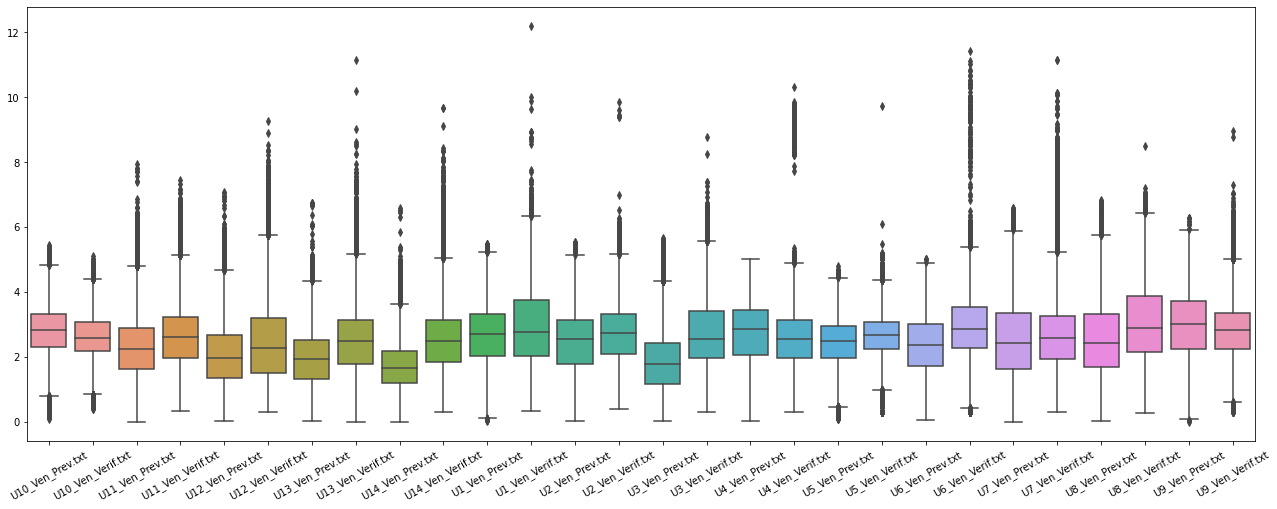

In [18]:
# Distribuição dos ventos previsto e real durante os 4 anos 
plt.figure(figsize=(22,8))
ax = sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

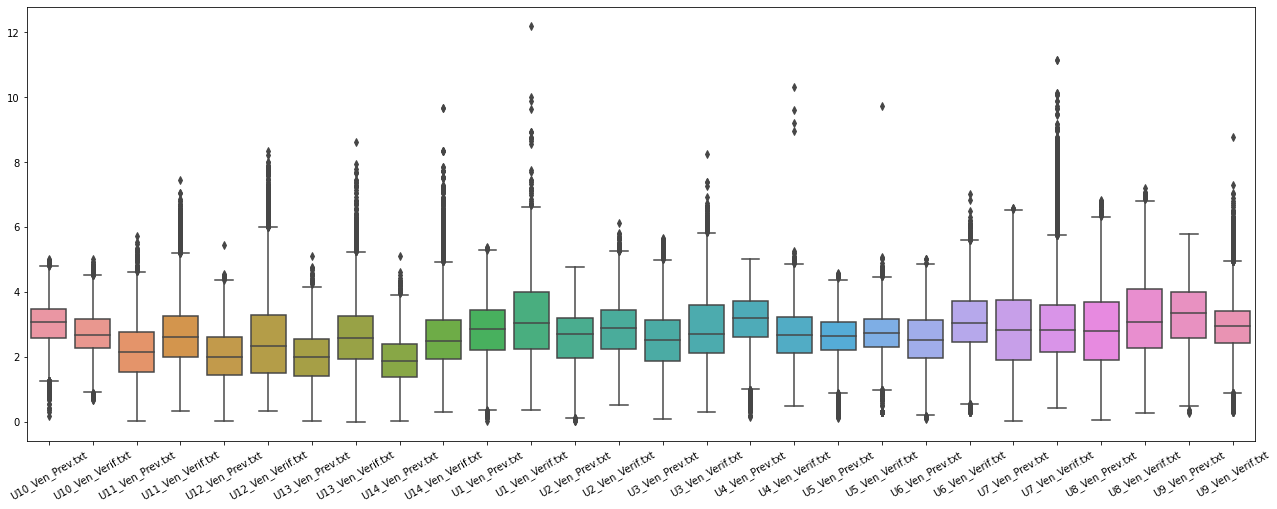

In [19]:
# Distribuição dos ventos previsto e real em 2017
plt.figure(figsize=(22,8))
ax = sns.boxplot(data=df[(df.index >= '2017-01-01') & (df.index < '2017-12-31')])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

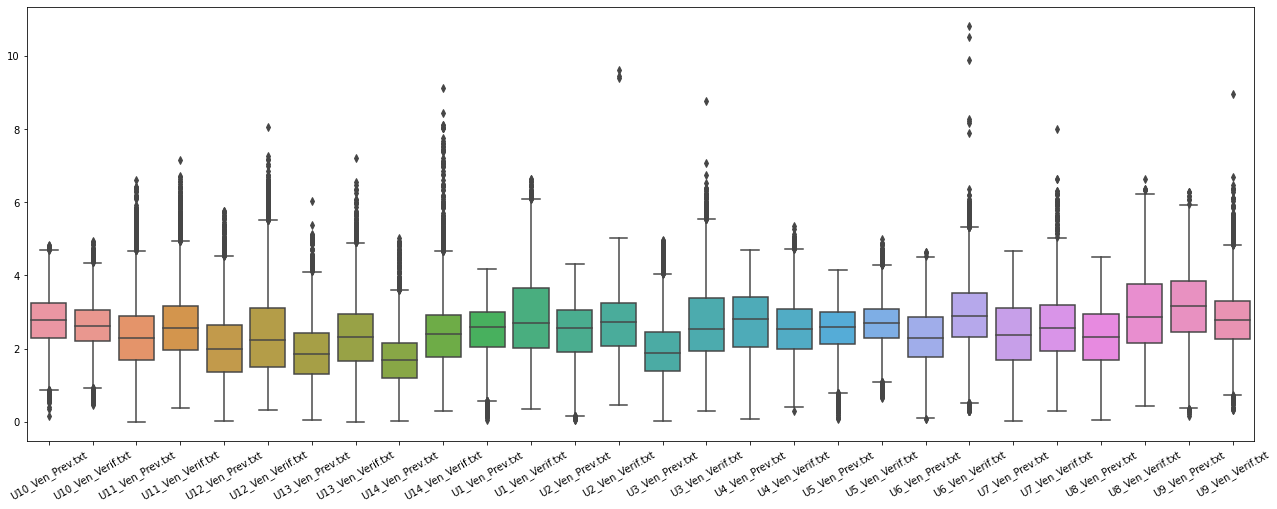

In [20]:
# Distribuição dos ventos previsto e real em 2018
plt.figure(figsize=(22,8))
ax = sns.boxplot(data=df[(df.index >= '2018-01-01') & (df.index < '2018-12-31')])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

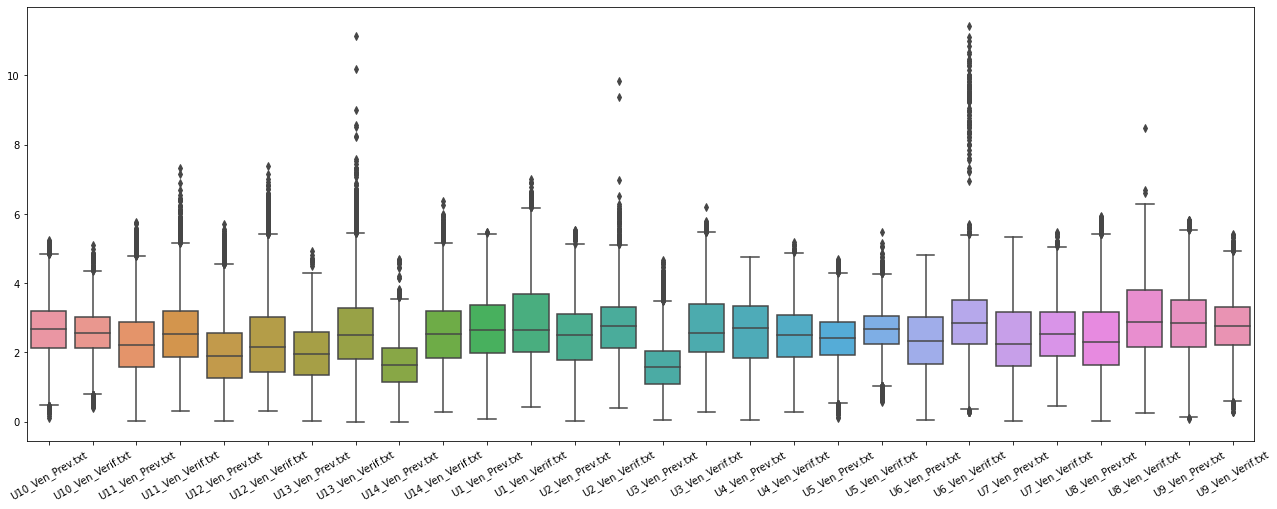

In [21]:
# Distribuição dos ventos previsto e real em 2019
plt.figure(figsize=(22,8))
ax = sns.boxplot(data=df[(df.index >= '2019-01-01') & (df.index < '2019-12-31')])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

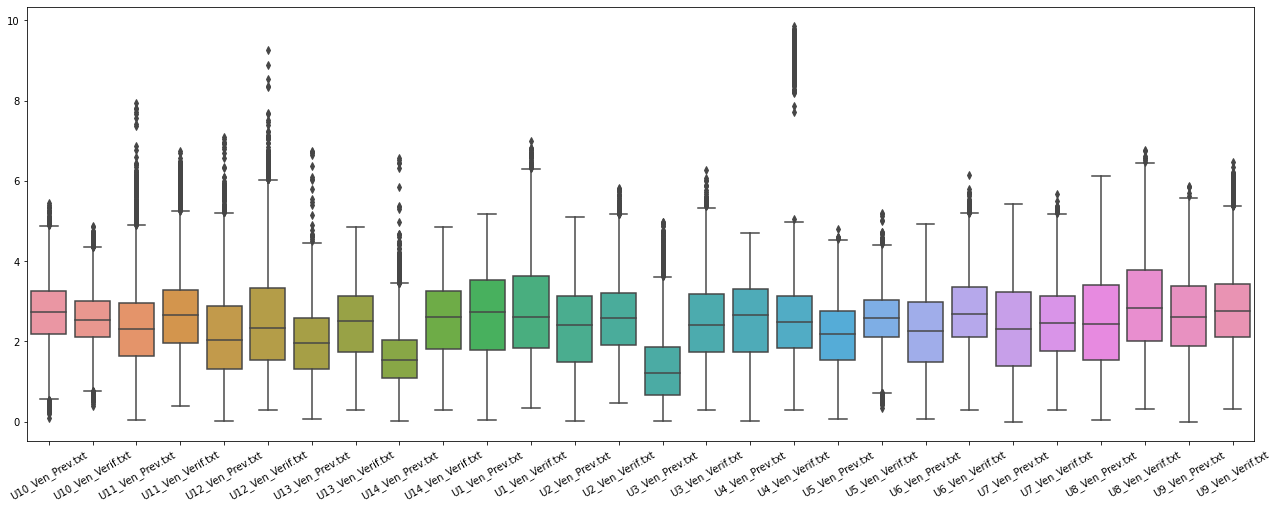

In [22]:
# Distribuição dos ventos previsto e real em 2020
plt.figure(figsize=(22,8))
ax = sns.boxplot(data=df[(df.index >= '2020-01-01') & (df.index < '2020-12-31')])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

> A matriz abaixo mostra a correlação entre os ventos modelados e reais de cada usina.

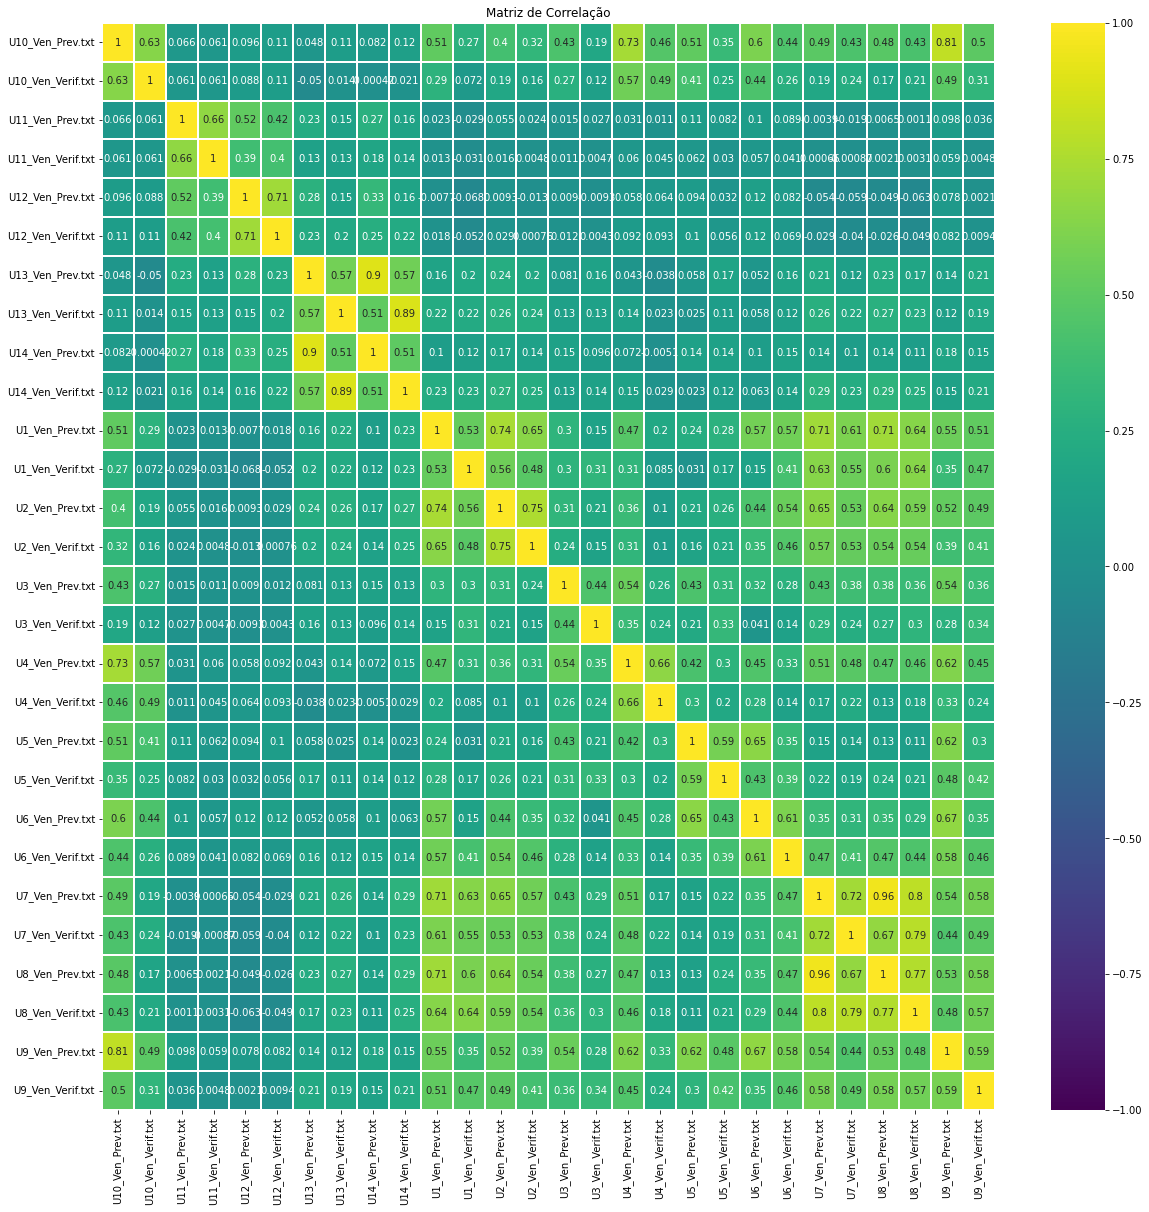

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='viridis', annot=True,linewidths=1)
plt.title('Matriz de Correlação')
plt.show()

In [36]:

df['U10_Ven_Prev.txt'].fillna(df['U10_Ven_Prev.txt'].median(), inplace=True) 
df['U11_Ven_Prev.txt'].fillna(df['U11_Ven_Prev.txt'].median(), inplace=True) 
df['U12_Ven_Prev.txt'].fillna(df['U12_Ven_Prev.txt'].median(), inplace=True) 
df['U13_Ven_Prev.txt'].fillna(df['U13_Ven_Prev.txt'].median(), inplace=True) 
df['U14_Ven_Prev.txt'].fillna(df['U14_Ven_Prev.txt'].median(), inplace=True)

df['U1_Ven_Prev.txt'].fillna(df['U1_Ven_Prev.txt'].median(), inplace=True)
df['U2_Ven_Prev.txt'].fillna(df['U2_Ven_Prev.txt'].median(), inplace=True) 
df['U3_Ven_Prev.txt'].fillna(df['U3_Ven_Prev.txt'].median(), inplace=True) 
df['U4_Ven_Prev.txt'].fillna(df['U4_Ven_Prev.txt'].median(), inplace=True) 
df['U5_Ven_Prev.txt'].fillna(df['U5_Ven_Prev.txt'].median(), inplace=True)

df['U6_Ven_Prev.txt'].fillna(df['U6_Ven_Prev.txt'].median(), inplace=True) 
df['U7_Ven_Prev.txt'].fillna(df['U7_Ven_Prev.txt'].median(), inplace=True) 
df['U8_Ven_Prev.txt'].fillna(df['U8_Ven_Prev.txt'].median(), inplace=True) 
df['U9_Ven_Prev.txt'].fillna(df['U9_Ven_Prev.txt'].median(), inplace=True) 


df_prev = df[['U1_Ven_Prev.txt','U2_Ven_Prev.txt','U3_Ven_Prev.txt',
             'U4_Ven_Prev.txt','U5_Ven_Prev.txt','U6_Ven_Prev.txt',
             'U7_Ven_Prev.txt','U8_Ven_Prev.txt','U9_Ven_Prev.txt',
             'U10_Ven_Prev.txt','U11_Ven_Prev.txt','U12_Ven_Prev.txt',
             'U13_Ven_Prev.txt','U14_Ven_Prev.txt']]
df_prev

,U1_Ven_Prev.txt,U2_Ven_Prev.txt,U3_Ven_Prev.txt,U4_Ven_Prev.txt,U5_Ven_Prev.txt,U6_Ven_Prev.txt,U7_Ven_Prev.txt,U8_Ven_Prev.txt,U9_Ven_Prev.txt,U10_Ven_Prev.txt,U11_Ven_Prev.txt,U12_Ven_Prev.txt,U13_Ven_Prev.txt,U14_Ven_Prev.txt
2017-01-01 00:00:00,2.9088,2.9579,3.5011,3.1577,2.9649,2.6004,4.5385,4.7348,4.5700,3.8796,2.2500,1.9661,1.9346,1.6629
2017-01-01 00:30:00,2.7862,2.8738,3.5572,3.1559,2.9316,2.5076,4.5385,4.5437,4.5069,3.8306,2.2500,1.9661,1.9346,1.6629
2017-01-01 01:00:00,2.6635,2.7897,3.6133,3.1542,2.8983,2.4147,4.5385,4.3527,4.4439,3.7815,2.2500,1.9661,1.9346,1.6629
2017-01-01 01:30:00,2.5356,2.6267,3.4976,3.0963,2.9053,2.3656,4.4579,4.1530,4.3843,3.7377,2.2500,1.9661,1.9346,1.6629
2017-01-01 02:00:00,2.4077,2.4638,3.3820,3.0385,2.9123,2.3166,4.3773,3.9532,4.3247,3.6939,2.2500,1.9661,1.9346,1.6629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:30:00,2.5969,2.5216,0.4118,3.1454,2.4182,3.1577,2.9018,3.1121,4.2213,3.1840,2.0309,1.0023,1.6787,1.7821
2020-12-31 22:00:00,2.9404,3.0525,0.2068,3.1261,2.2570,2.9965,3.2137,3.4275,4.1320,3.0701,1.9381,0.9252,1.5701,1.6682
2020-12-31 22:30:00,2.9930,2.9176,0.2611,3.1769,2.0975,2.6828,3.3171,3.6501,3.8726,3.0297,1.6542,0.9042,1.4124,1.3703
2020-12-31 23:00:00,3.0455,2.7827,0.3154,3.2278,1.9381,2.3691,3.4205,3.8726,3.6133,2.9894,1.3703,0.8832,1.2547,1.0724


In [37]:
# Criando coluna "viés-medio"

usinas = ['U1','U2','U3','U4','U4','U5','U6','U7','U8','U9','U10','U11','U12','U13','U14']
y=0
vies = []
for c in usinas:
  vies.append(df.loc[:, c+'_Ven_Prev.txt'] - df.loc[:, c+'_Ven_Verif.txt'])

viesM = sum(vies)/len(vies)

df_prev['viés-médio'] = viesM
df_prev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,U1_Ven_Prev.txt,U2_Ven_Prev.txt,U3_Ven_Prev.txt,U4_Ven_Prev.txt,U5_Ven_Prev.txt,U6_Ven_Prev.txt,U7_Ven_Prev.txt,U8_Ven_Prev.txt,U9_Ven_Prev.txt,U10_Ven_Prev.txt,U11_Ven_Prev.txt,U12_Ven_Prev.txt,U13_Ven_Prev.txt,U14_Ven_Prev.txt,viés-médio
2017-01-01 00:00:00,2.9088,2.9579,3.5011,3.1577,2.9649,2.6004,4.5385,4.7348,4.5700,3.8796,2.25,1.9661,1.9346,1.6629,0.220093
2017-01-01 00:30:00,2.7862,2.8738,3.5572,3.1559,2.9316,2.5076,4.5385,4.5437,4.5069,3.8306,2.25,1.9661,1.9346,1.6629,0.112433
2017-01-01 01:00:00,2.6635,2.7897,3.6133,3.1542,2.8983,2.4147,4.5385,4.3527,4.4439,3.7815,2.25,1.9661,1.9346,1.6629,0.008087
2017-01-01 01:30:00,2.5356,2.6267,3.4976,3.0963,2.9053,2.3656,4.4579,4.1530,4.3843,3.7377,2.25,1.9661,1.9346,1.6629,-0.046153
2017-01-01 02:00:00,2.4077,2.4638,3.3820,3.0385,2.9123,2.3166,4.3773,3.9532,4.3247,3.6939,2.25,1.9661,1.9346,1.6629,-0.005587


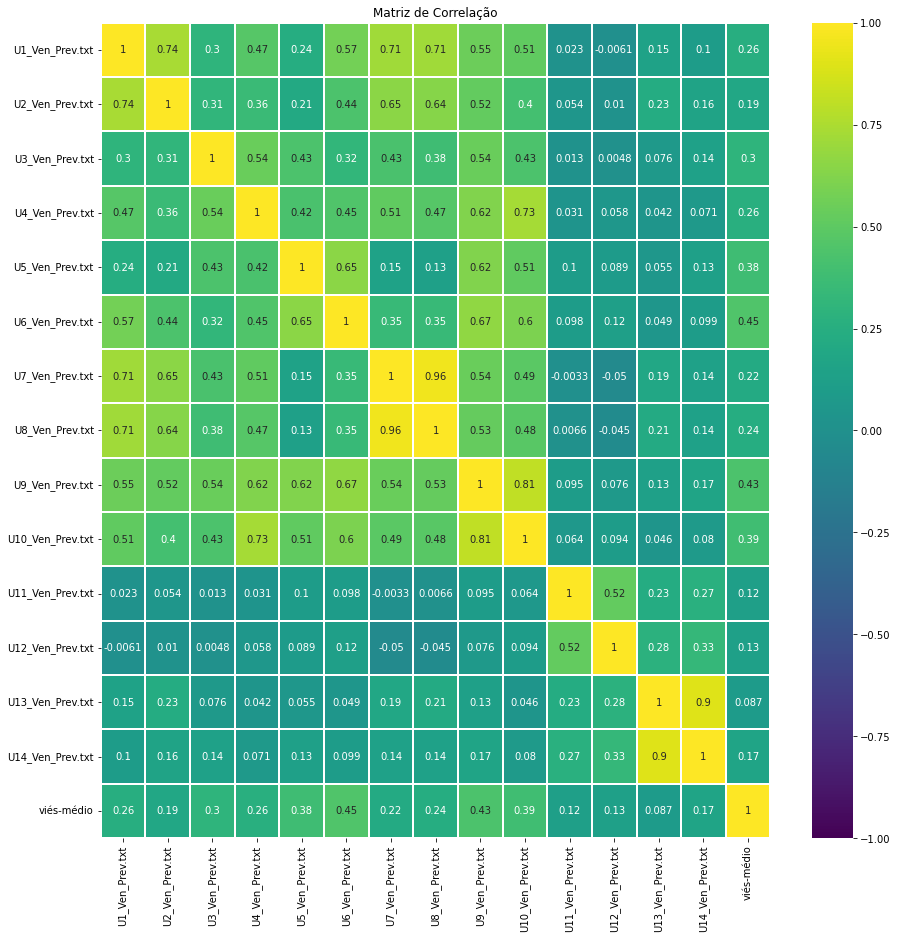

In [38]:
plt.figure(figsize=(15,15))
sns.heatmap(df_prev.corr(), vmin=-1, vmax=1, cmap='viridis', annot=True,linewidths=1)
plt.title('Matriz de Correlação')
plt.show()

* As usinas 11 e 13 carregam menor impacto no viés médio de todas as outras usinas.
* As usinas 14 e 13 tem forte correlação entre si com relação ao modelo de previsão de vento.

---


#### <b>4. Pré-Processamento dos Dados</b>

Nesta etapa iremos realizar o tratamento dos dados, removendo ou injetando dados que são faltantes. Além disso:

* Criação de novas features, enriquecendo a base de dados;

> Aplicando método de substituir os dados faltantes pela mediana

In [33]:
df['U10_Ven_Prev.txt'].fillna(df['U10_Ven_Prev.txt'].median(), inplace=True) 
df['U11_Ven_Prev.txt'].fillna(df['U11_Ven_Prev.txt'].median(), inplace=True) 
df['U12_Ven_Prev.txt'].fillna(df['U12_Ven_Prev.txt'].median(), inplace=True) 
df['U13_Ven_Prev.txt'].fillna(df['U13_Ven_Prev.txt'].median(), inplace=True) 
df['U14_Ven_Prev.txt'].fillna(df['U14_Ven_Prev.txt'].median(), inplace=True)

df['U1_Ven_Prev.txt'].fillna(df['U1_Ven_Prev.txt'].median(), inplace=True)
df['U2_Ven_Prev.txt'].fillna(df['U2_Ven_Prev.txt'].median(), inplace=True) 
df['U3_Ven_Prev.txt'].fillna(df['U3_Ven_Prev.txt'].median(), inplace=True) 
df['U4_Ven_Prev.txt'].fillna(df['U4_Ven_Prev.txt'].median(), inplace=True) 
df['U5_Ven_Prev.txt'].fillna(df['U5_Ven_Prev.txt'].median(), inplace=True)

df['U6_Ven_Prev.txt'].fillna(df['U6_Ven_Prev.txt'].median(), inplace=True) 
df['U7_Ven_Prev.txt'].fillna(df['U7_Ven_Prev.txt'].median(), inplace=True) 
df['U8_Ven_Prev.txt'].fillna(df['U8_Ven_Prev.txt'].median(), inplace=True) 
df['U9_Ven_Prev.txt'].fillna(df['U9_Ven_Prev.txt'].median(), inplace=True) 

round(df.isnull().sum()/len(df.index), 2)*100 # Porcentagem de dados faltantes 

U10_Ven_Prev.txt     0.0
U10_Ven_Verif.txt    0.0
U11_Ven_Prev.txt     0.0
U11_Ven_Verif.txt    0.0
U12_Ven_Prev.txt     0.0
U12_Ven_Verif.txt    0.0
U13_Ven_Prev.txt     0.0
U13_Ven_Verif.txt    0.0
U14_Ven_Prev.txt     0.0
U14_Ven_Verif.txt    0.0
U1_Ven_Prev.txt      0.0
U1_Ven_Verif.txt     0.0
U2_Ven_Prev.txt      0.0
U2_Ven_Verif.txt     0.0
U3_Ven_Prev.txt      0.0
U3_Ven_Verif.txt     0.0
U4_Ven_Prev.txt      0.0
U4_Ven_Verif.txt     0.0
U5_Ven_Prev.txt      0.0
U5_Ven_Verif.txt     0.0
U6_Ven_Prev.txt      0.0
U6_Ven_Verif.txt     0.0
U7_Ven_Prev.txt      0.0
U7_Ven_Verif.txt     0.0
U8_Ven_Prev.txt      0.0
U8_Ven_Verif.txt     0.0
U9_Ven_Prev.txt      0.0
U9_Ven_Verif.txt     0.0
dtype: float64

In [ ]:
# Abordagens de KNN para valores faltantes dos ventos


#### <b>5. Predição do Viés por Modelos de Regressão</b>

##### <b>5.1 Kernel Ridge Regression </b>

In [ ]:
# Testar o Kernel Ridge para diferentes janelas temporais
# Usar Grid Search para o treinamento, testando diferentes tipos de kernel


# Estático: pode-se calibrar os parâmetros do modelo com uma parte do histórico e realizar o teste com outra. Ex.: calibração (treinamento e/ou validação) com os anos de 2017 e 2018 e avaliação de desempenho (teste) 
# com os anos de 2019 e 2020. 

# Os períodos são apenas para exemplificação, devendo ser encolhido pelo avaliador.


Montando dataframe que será modelado

In [ ]:
df_prev = df.loc[:,['U10_Ven_Prev.txt', 'U11_Ven_Prev.txt', 'U12_Ven_Prev.txt',
                  'U13_Ven_Prev.txt', 'U14_Ven_Prev.txt', 'U1_Ven_Prev.txt',
                  'U2_Ven_Prev.txt','U3_Ven_Prev.txt', 'U4_Ven_Prev.txt',
                  'U5_Ven_Prev.txt', 'U6_Ven_Prev.txt', 'U7_Ven_Prev.txt',
                  'U8_Ven_Prev.txt', 'U9_Ven_Prev.txt']]
                  
df_prev.head()

,U10_Ven_Prev.txt,U11_Ven_Prev.txt,U12_Ven_Prev.txt,U13_Ven_Prev.txt,U14_Ven_Prev.txt,U1_Ven_Prev.txt,U2_Ven_Prev.txt,U3_Ven_Prev.txt,U4_Ven_Prev.txt,U5_Ven_Prev.txt,U6_Ven_Prev.txt,U7_Ven_Prev.txt,U8_Ven_Prev.txt,U9_Ven_Prev.txt
2017-01-01 00:00:00,3.8796,2.25,1.9661,1.9346,1.6629,2.9088,2.9579,3.5011,3.1577,2.9649,2.6004,4.5385,4.7348,4.5700
2017-01-01 00:30:00,3.8306,2.25,1.9661,1.9346,1.6629,2.7862,2.8738,3.5572,3.1559,2.9316,2.5076,4.5385,4.5437,4.5069
2017-01-01 01:00:00,3.7815,2.25,1.9661,1.9346,1.6629,2.6635,2.7897,3.6133,3.1542,2.8983,2.4147,4.5385,4.3527,4.4439
2017-01-01 01:30:00,3.7377,2.25,1.9661,1.9346,1.6629,2.5356,2.6267,3.4976,3.0963,2.9053,2.3656,4.4579,4.1530,4.3843
2017-01-01 02:00:00,3.6939,2.25,1.9661,1.9346,1.6629,2.4077,2.4638,3.3820,3.0385,2.9123,2.3166,4.3773,3.9532,4.3247


Adicionando feature "viés" ao dataset, cujo valor é o viés médio de todos os viéses das usinas daquele mesmo período

###### <b> 5.1.1 Conjunto de Treino e Teste </b>

Primeiro, será realizado um estudo do comportamento do modelo aplicando a estratégia <b>estática</b> na<b> Usina 1</b>. Funciona da seguinte forma: 
* Os arquivos disponibilizados possuem quatro anos de dados, 2017 até 2018.
* Calibra-se os parâmetros do modelo com uma parte do histórico e
realizar o teste com outra. Ex.: calibração (treinamento e/ou validação) com os
anos de 2017 e 2018 e avaliação de desempenho (teste) com os anos de 2019 e 2020.

In [ ]:
# Separar conjuntos de treino e teste de acordo com os anos

In [ ]:
X_treino = 
y_treino = 
X_test = 
y_test = 

###### <b> 5.1.2 Escolha dos parâmetros </b>


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

parametros = {'alpha':[0,0.5,1,1.5],'kernel':['linear']}
krr = KernelRidge()

grid_search = GridSearchCV(krr, parametros, cv=5, scoring='')

grid_search.fit(X_treino, y_treino)

print(grid_search.best_params_)

###### <b> 5.1.3 Treinamento do modelos </b>

In [ ]:
krr.fit(X_treino, y_treino)

In [ ]:
krr.score(X_teste, y_test)

###### <b>5.1.4 Resultados:</b>

##### <b>5.2 Support Vector Regression (SVR) </b>

###### <b> 5.2.1 Conjunto de Treino e Teste </b>

Primeiro, será realizado um estudo do comportamento do modelo aplicando a estratégia <b>estática</b> na<b> Usina 1</b>. Funciona da seguinte forma: 
* Os arquivos disponibilizados possuem quatro anos de dados, 2017 até 2018.
* Calibra-se os parâmetros do modelo com uma parte do histórico e
realizar o teste com outra. Ex.: calibração (treinamento e/ou validação) com os
anos de 2017 e 2018 e avaliação de desempenho (teste) com os anos de 2019 e 2020.

In [114]:
# Separar conjuntos de treino e teste de acordo com os anos

In [ ]:
X_treino = 
y_treino = 
X_test = 
y_test = 

###### <b> 5.2.2 Escolha dos parâmetros </b>


###### <b> 5.2.3 Treinamento do modelo </b>

###### <b> 5.2.4 Resultados </b>